In [227]:
import numpy as np
import csv
import os
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [90]:
nteams = 20
nmatches = (nteams-1)*2

Data Pre-processing

In [84]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [274]:
def season_game_mat(season_dir, team_map):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if '/1-' in entry.path:
            csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        next(reader)
        for row in reader:
            team1 = team_map[row[1]]
            team2 = team_map[row[2]]

            score = row[3].split('-')

            # 1 for win, 0 for draw, -1 for loss

            if(int(score[0]) > int(score[1])):
                game_mat[team1, team_index[team1]] = 1
                game_mat[team2, team_index[team2]] = -1
            elif(int(score[0]) < int(score[1])):
                game_mat[team1, team_index[team1]] = -1
                game_mat[team2, team_index[team2]] = 1

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [283]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1

In [191]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [192]:
def disc_error(outputs, targets):
    rounded_outputs = np.round(outputs)
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(rounded_outputs[i][j]) != int(targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [285]:
ntraining = 45
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntraining:]

X_training = np.reshape(np.array(training_game_mats), (ntraining*nmatches, nteams))
lengths = np.full(ntraining, nmatches)

In [101]:
# X_training = []
# X_testing = []

# for game_mat in game_mats:
#     X_training.append(game_mat[:ntraining])
#     X_testing.append(game_mat[ntraining:])
    
# X_training = np.reshape(np.array(X_training), (nseasons*ntraining, nteams))
# lengths = np.full(nseasons, ntraining)
# X_testing = np.reshape(np.array(X_testing), (nseasons*ntesting, nteams))

In [262]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [298]:
states = [30, 50, 100, 200]
models = {}

In [301]:
for state in states:
    key = str(state) + '_states'
    models[key] = hmm.GaussianHMM(n_components=state, covariance_type="diag", n_iter=500)
    print(models[key].fit(X_training, lengths))

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=30, n_iter=500, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)
GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=50, n_iter=500, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)
GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=100, n_iter=500, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)
GaussianHMM(algorithm='viterbi', covariance_type='diag', 

In [263]:
def nextObs(model, seq):
    last_state = model.decode(seq)[1][-1]
    next_state = np.argmax(model.transmat_[last_state])
    return model.means_[next_state]

In [264]:
def score(model, key):
    training_accs = []
    training_errs = []

    with open('hmm_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        for i in range(1, nmatches):
            outputs = []
            targets = []
            for game_mat in training_game_mats:
                outputs.append(nextObs(model, game_mat[:i]))
                targets.append(game_mat[i])

            acc = 1 - disc_error(np.array(outputs), np.array(targets))
            eerr = eucl_error(np.array(outputs), np.array(targets))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('hmm_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        for i in range(1, nmatches):
            outputs = []
            targets = []
            for game_mat in testing_game_mats:
                outputs.append(nextObs(model, game_mat[:i]))
                targets.append(game_mat[i])

            acc = 1 - disc_error(np.array(outputs), np.array(targets))
            eerr = eucl_error(np.array(outputs), np.array(targets))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [328]:
for state in states:
    key = str(state) + '_states'
    print(key)
    score(models[key], key)

30_states
50_states
100_states
200_states


In [253]:
def plot(y, ylabel, title, imname):
    x = range(1,nmatches)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,nmatches,0,1])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('hmmplots/' + imname + '.png')
    plt.show()

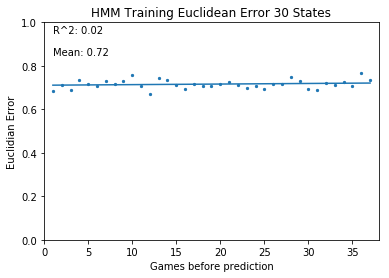

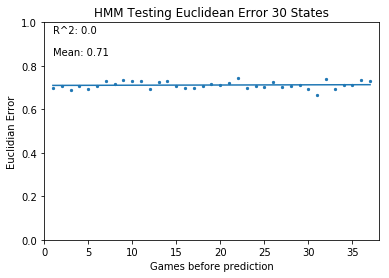

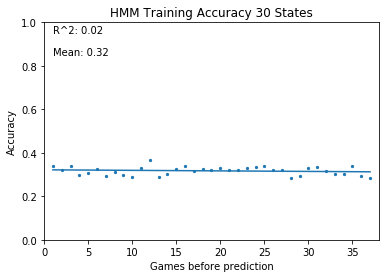

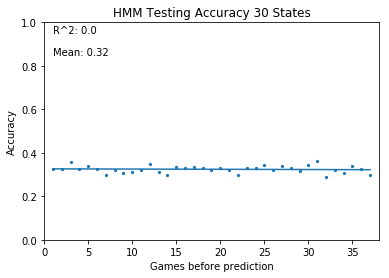

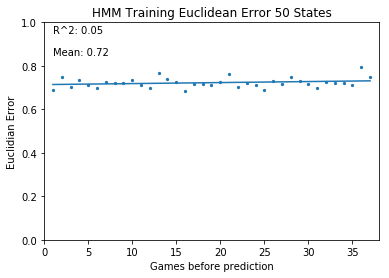

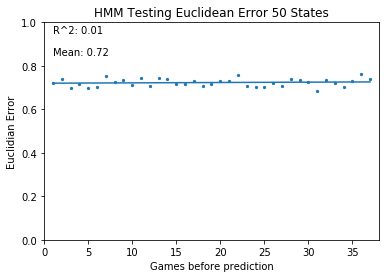

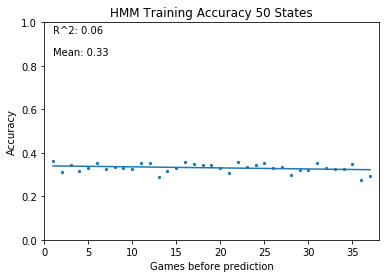

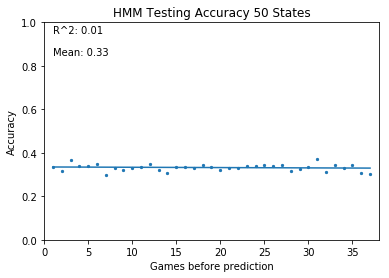

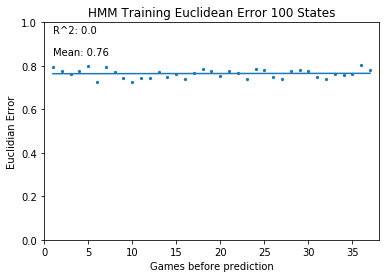

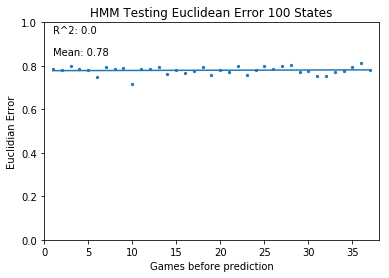

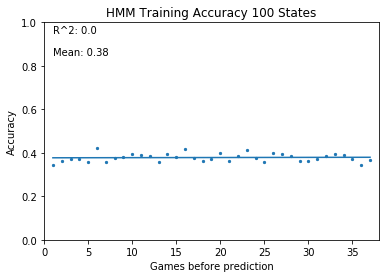

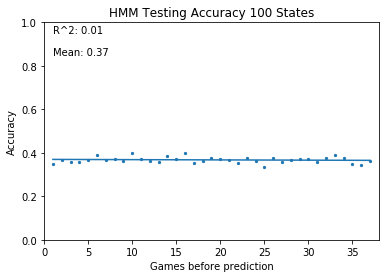

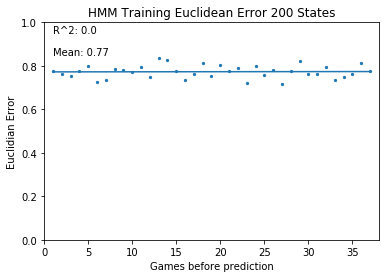

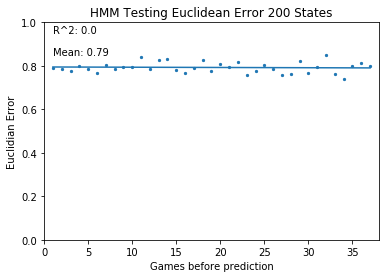

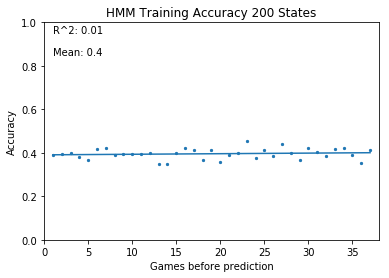

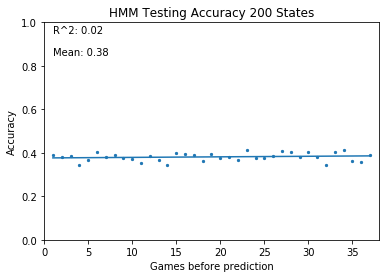

In [307]:
for state in states:
    key = str(state)+'_states'
    title = ' ' + str(state) + ' States'
    plot(training_errs_dict[key], 'Euclidian Error', 'HMM Training Euclidean Error' + title, 'hmm_training_error_plot_'+key)
    plot(testing_errs_dict[key], 'Euclidian Error', 'HMM Testing Euclidean Error' + title, 'hmm_testing_error_plot_'+key)
    plot(training_accs_dict[key], 'Accuracy', 'HMM Training Accuracy' + title, 'hmm_training_accuracy_plot_'+key)
    plot(testing_accs_dict[key], 'Accuracy', 'HMM Testing Accuracy' + title, 'hmm_testing_accuracy_plot_'+key)



In [320]:
np.unique(np.array(game_mats), return_counts=True)[1]/np.array(game_mats).size

array([ 0.36428865,  0.2714227 ,  0.36428865])

In [326]:
np.unique(np.array(training_game_mats), return_counts=True)[1]/np.array(training_game_mats).size

array([ 0.36733918,  0.26532164,  0.36733918])

In [327]:
np.unique(np.array(testing_game_mats), return_counts=True)[1]/np.array(testing_game_mats).size

array([ 0.36216374,  0.27567251,  0.36216374])